<a href="https://colab.research.google.com/github/beinghorizontal/Quantext/blob/main/lstm_ohlc_denoised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

# Import essential libraries

In [4]:
import yfinance as yf
import datetime

# Download the historical data from Yahoo finance for 15 years data, replace  'days=15' to change the years accordingly

In [9]:
ticker_symbol = "RELIANCE.NS"
start_date = datetime.datetime.now() - datetime.timedelta(days=15 * 365)
end_date = datetime.datetime.now()
print(start_date,'\n',end_date)

2009-03-12 10:50:23.164085 
 2024-03-08 10:50:32.122308


In [10]:
df1 = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [54]:
df = df1.copy()

In [12]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import torch
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.layers import Input  # Replace with your backend's import syntax


In [13]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Alternate method to download historical data You need Alpha Vantage free API key. Store that key in the text folder and replace the path. For this script I have Used  the Yahoo finance data the only difference will be the column name which will be capitalized Or in small letters

In [ ]:
#!pip install pandas-dataloader
#from pandas_datareader import data
# Download stock market data (e.g., Apple Inc.)
# with open('G:/anaconda/Scripts/data/alpha_vantage/key.txt', 'r') as f:
#     key = f.read()
# symbol = 'AAPL'  # Ticker symbol for Apple Inc.
# df = data.DataReader(symbol, "av-daily", start=datetime(2017, 2, 9),
#                     end=datetime(2024, 2, 26),
#                     api_key=key)

# We will try to normalize the values without calculating the returns. It just for the demonstration to see how it will be difficult for the LSTM model to learn effectively

# Let's plot unscaled  data 1st

In [ ]:
# df['Close'].plot()
# plt.show()

# Now we will normalize it without calculating the returns and plot the normalized closed value.This is the most frequent error I have seen traders do as you can see even after transforming the data only the scale will be different but you are not essentially removing any underlying trend.Model is still highly sensitive to the price itself so imagine if the price 0.2 in the skilled format has never come what is the point of the model to train on that kind of data

In [ ]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# df_test = df.copy()
# scaled_data = scaler.fit_transform(df_test[['Open', 'High', 'Low', 'Close','Volume']])
# plt.plot(scaled_data[:, 3])

# Add candlestick patterns using pandas-ta and ta-lib

# This is for colab notebook only or Linux , for Windows use <conda install -c conda-forge ta-lib>


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
#import talib

In [19]:
!pip install pandas_ta

In [ ]:
import pandas_ta as ta
import pandas as pd
#df_patterns = df.ta.cdl_pattern(name="all")
#single_column_df = pd.DataFrame(df_patterns.sum(axis=1), columns=["All_Candle_Patterns"])
#df = pd.concat([df,single_column_df],axis=1)

# Create Various columns with indicators based on pandas_ta  library, binary output methodThat is less noise but less opportunities to learn the pattern due to loss of information

In [ ]:
# df['sma_small_delta'] = np.where(df.ta.sma(length=5) > df.ta.sma(length=10),1,0)
# df['wma_small_delta'] = np.where(df.ta.wma(length=10) > df.ta.wma(length=20),1,0)
# df['sma_long_delta'] = np.where(df.ta.sma(length=20) > df.ta.sma(length=50),1,0)
# df['rsi_delta'] = np.where(df.ta.rsi(length=7) > df.ta.rsi(length=14),1,0)
# df['vwma_small_delta'] = np.where(df.ta.vwma(length=5) > df.ta.vwma(length=10),1,0)
# df['vwma_long_delta'] = np.where(df.ta.vwma(length=10) > df.ta.vwma(length=20),1,0)
#df['percent_return_20'] = df.ta.percent_return(length=20)
# df_vortex = df.ta.vortex(length=14)  # Vortex indicator has two oscillators positive and negative. We calculate the delta
# df_vortex['plus_delta'] = np.where(df_vortex['VTXP_14'] > df_vortex['VTXM_14'],1,0)
# df['vortex_plus_delta'] = df_vortex['plus_delta']


# Create columns best on pandas_ta library, non binary method that is more noise but more opportunities to learn the pattern

In [55]:
df['sma_small_delta'] = (df.ta.sma(length=5) - df.ta.sma(length=10))/df.ta.sma(length=10)
df['wma_small_delta'] = (df.ta.wma(length=10) - df.ta.wma(length=20))/df.ta.wma(length=20)
df['sma_long_delta'] = (df.ta.sma(length=20) - df.ta.sma(length=50))/df.ta.sma(length=50)
df['rsi_delta'] = (df.ta.rsi(length=7) - df.ta.rsi(length=14)) / df.ta.rsi(length=14)
df['vwma_small_delta'] = (df.ta.vwma(length=5) - df.ta.vwma(length=10))/df.ta.vwma(length=10) # Volume weighted moving average
df['vwma_long_delta'] = (df.ta.vwma(length=10) - df.ta.vwma(length=20))/df.ta.vwma(length=20)
df['percent_return_20'] = df.ta.percent_return(length=20)
df['atr'] = df.ta.atr()/df['Close']
df['roc5'] = df.ta.roc(length=5)
df['roc'] = df.ta.roc()


# plot 1 by 1 to confirm stationary properties

In [ ]:
#df[['sma_small_delta']].tail(200).plot() # Zoom in view to see if there is randomness or some cyclical pattern


In [ ]:
#df.ta.percent_return(length=20)

In [ ]:
#df.ta.indicators()

In [ ]:
#help(ta.vwma)


<Axes: xlabel='Date'>

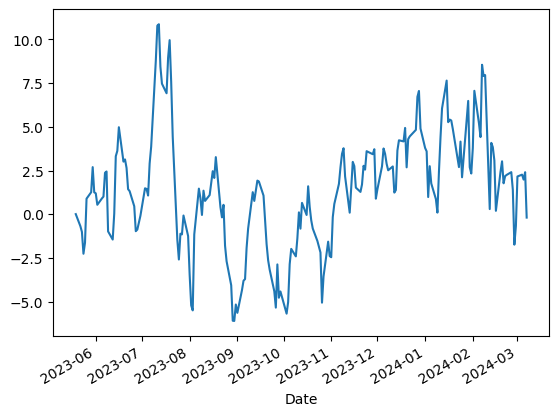

In [23]:
df.ta.roc().tail(200).plot()
#plt.show()

In [56]:
df = df.dropna()

# check what dataframe looks like because we are going to normalize the remaining data later
# Most of the values have positive and negative numbers. So we will use minmax scaler range is equal to -1, 1

In [57]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [58]:
print(df.columns.to_list())

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'sma_small_delta', 'wma_small_delta', 'sma_long_delta', 'rsi_delta', 'vwma_small_delta', 'vwma_long_delta', 'percent_return_20', 'atr', 'roc5', 'roc']


In [59]:
columns_to_norm = ['sma_small_delta', 'wma_small_delta', 'sma_long_delta', 'rsi_delta', 'vwma_small_delta', 'vwma_long_delta', 'percent_return_20', 'atr', 'roc5', 'roc']
#columns_to_norm = ['All_Candle_Patterns']

for col in columns_to_norm:
    df[[col]] = scaler.fit_transform(df[[col]])


<ipython-input-59-005119d364f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[col]] = scaler.fit_transform(df[[col]])
<ipython-input-59-005119d364f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[col]] = scaler.fit_transform(df[[col]])
<ipython-input-59-005119d364f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

# Create 5day sma for target

In [60]:
df['15sma'] = df['Close'].shift(-15).rolling(15).mean()

<ipython-input-60-17c4efc8a48e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['15sma'] = df['Close'].shift(-15).rolling(15).mean()


# create binary target

In [61]:
df['target'] = (df['15sma'] > df['Close']).astype(int)

<ipython-input-61-ccec5cb6c056>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = (df['15sma'] > df['Close']).astype(int)


In [62]:
df = df.dropna()
print(df[['15sma','target']].head(10))

                 15sma  target
Date                          
2009-06-16  457.656287       0
2009-06-17  454.277826       0
2009-06-18  451.662073       0
2009-06-19  447.603198       0
2009-06-22  444.531801       0
2009-06-23  441.464978       0
2009-06-24  439.544118       0
2009-06-25  439.198195       0
2009-06-26  437.793933       0
2009-06-29  436.975604       0


# drop unwanted columns

In [63]:
df = df.drop(['Open', 'High','Low', 'Close', 'Adj Close', 'Volume','15sma','atr','rsi_delta'],axis=1)

In [64]:
df = df.dropna()

# Create target and features

In [65]:
features = df.drop('target', axis=1).values
target = df['target'].values

# create sequences of a specific length for features and the corresponding target.

In [66]:
def create_sequences(features, target, sequence_length):
    X = []
    y = []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 15
X, y = create_sequences(features, target, sequence_length)

# split X and Y into training and validation sets

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4,shuffle=False)


In [68]:
print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Training shape: (2164, 15, 8)
Validation shape: (1443, 15, 8)


In [69]:
num_features = X_train.shape[2]
print(num_features)

8


In [70]:
print(features)

[[0.58532283 0.62382787 0.86333379 ... 0.36294508 0.38185516 0.38491264]
 [0.49482834 0.57051281 0.84050139 ... 0.35528032 0.23103367 0.34418919]
 [0.40872254 0.51846815 0.82209399 ... 0.35948355 0.21851638 0.31701686]
 ...
 [0.59138932 0.70725512 0.69827439 ... 0.47019135 0.59287339 0.53628348]
 [0.60088597 0.70607256 0.69458252 ... 0.46397417 0.59561246 0.53258512]
 [0.59952646 0.6985444  0.69297978 ... 0.47115234 0.56228317 0.52117469]]


In [71]:
from keras.optimizers import Adam
from keras.regularizers import l1_l2,l1,l2
from keras.layers import LeakyReLU
# inputs = Input(shape=(sequence_length, X_train.sha))  # Replace with appropriate values


# Build the LSTM model
model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
# model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu', kernel_regularizer=l1(0.001)))
model.add(LSTM(152, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(Dropout(0.5))
model.add(LSTM(92, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(Dropout(0.4))
model.add(LSTM(52, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
# # model.add(Dropout(0.4))
model.add(LSTM(32, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
# # model.add(Dropout(0.4))
# model.add(LSTM(8, return_sequences=True, activation='tanh'))  # Add an extra LSTM layer
# # # model.add(Dropout(0.4))
model.add(LSTM(8))  # Add an extra LSTM layer
# model.add(Dense(1, activation='sigmoid',  kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.001) # default is 0.001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
early_stopping = EarlyStopping(monitor='val_loss',    # Monitor the val loss
                               patience=150,           # Num epochs; if no improvement training will be stopped
                               verbose=1,
                               mode='min',            # The training will stop when the quantity monitored has stopped decreasing
                               restore_best_weights=True) # Restores model weights from the epoch with the best value of the monitored quantity.

In [73]:

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('/content/best_model.keras',   # Path where to save the model
                                   monitor='val_loss',   # Monitor the validation loss
                                   save_best_only=True,  # The latest best model according to the quantity monitored will not be overwritten
                                   mode='min',           # The training will save the model when the quantity monitored has decreased
                                   verbose=1)


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)


Epoch 1/1000
136/136 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5240
Epoch 1: val_loss improved from inf to 0.68581, saving model to /content/best_model.keras
136/136 [==============================] - 21s 108ms/step - loss: 0.6922 - accuracy: 0.5240 - val_loss: 0.6858 - val_accuracy: 0.5731
Epoch 2/1000
136/136 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5305
Epoch 2: val_loss improved from 0.68581 to 0.68496, saving model to /content/best_model.keras
136/136 [==============================] - 14s 102ms/step - loss: 0.6916 - accuracy: 0.5305 - val_loss: 0.6850 - val_accuracy: 0.5731
Epoch 3/1000
136/136 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5305
Epoch 3: val_loss improved from 0.68496 to 0.68435, saving model to /content/best_model.keras
136/136 [==============================] - 13s 96ms/step - loss: 0.6919 - accuracy: 0.5305 - val_loss: 0.6844 - val_accuracy: 0.5731
Epoch 4/1000
136/136 [=====

# plot val and train accuracy

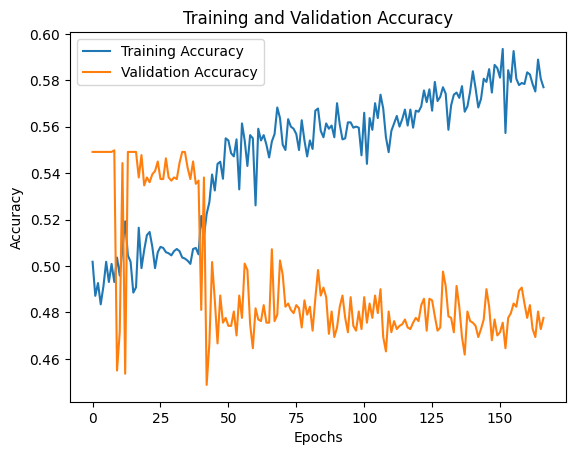

In [53]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


#plot model architecture

In [ ]:
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
